In [4]:
import os
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as sig
import scipy.io as spio


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import community
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util


%matplotlib inline

In [5]:
configs = ["ns_3_mreg_3_msub_1_nf_32", "ns_3_mreg_3_msub_2_nf_32", "ns_3_mreg_3_msub_3_nf_32",
           "ns_3_mreg_3_msub_4_nf_32",  "ns_3_mreg_3_msub_5_nf_32"]
conn = "linw"
preproc = "dicer"
modelname = "AB"

In [6]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp_{conn}_{preproc}/dataset.npz")
runs = [util.select_run(f"hcp_{conn}_{preproc}", modelname, config, [0,1], "hcp") for config in configs]
direcs = [f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"  for run, config in 
          zip(runs, configs)]
paramss = [ndsv.Params.from_file(os.path.join(direc, "parameters.npz")) for direc in direcs]

In [7]:
nsub, nreg, _, nt = ds.y.shape
subjects = np.r_[:nsub]
regions = np.r_[:nreg]
nconf = len(configs)

## Analysis

In [8]:
paramss[1].thetasub.shape

(8, 2, 2)

In [9]:
def nscatter(xmu, xstd, ymu, ystd, c=None, cmap=None, vmin=None, vmax=None, **args):
    n = len(xmu)
    
    if c is not None:
        cmap = matplotlib.cm.get_cmap(cmap)
        if vmin is None: vmin = np.min(c)
        if vmax is None: vmax = np.max(c)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    for i in range(n):
        color = 'k' if (c is None) else cmap(norm(c[i]))
        plt.plot([xmu[i]-xstd[i], xmu[i]+xstd[i]], [ymu[i], ymu[i]], color=color, **args)
        plt.plot([xmu[i], xmu[i]], [ymu[i]-ystd[i], ymu[i]+ystd[i]], color=color, **args)
    
    if c:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        return sm   
    else:
        return None

<Figure size 300x300 with 0 Axes>

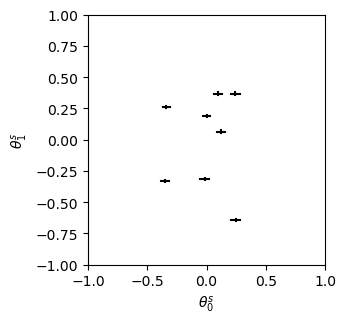

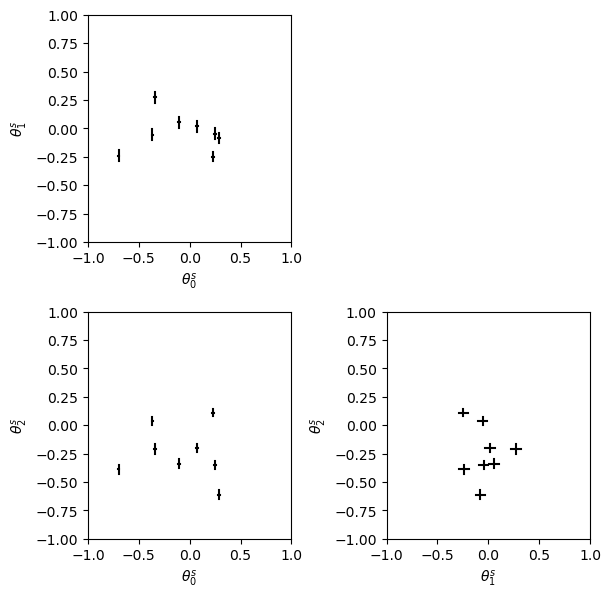

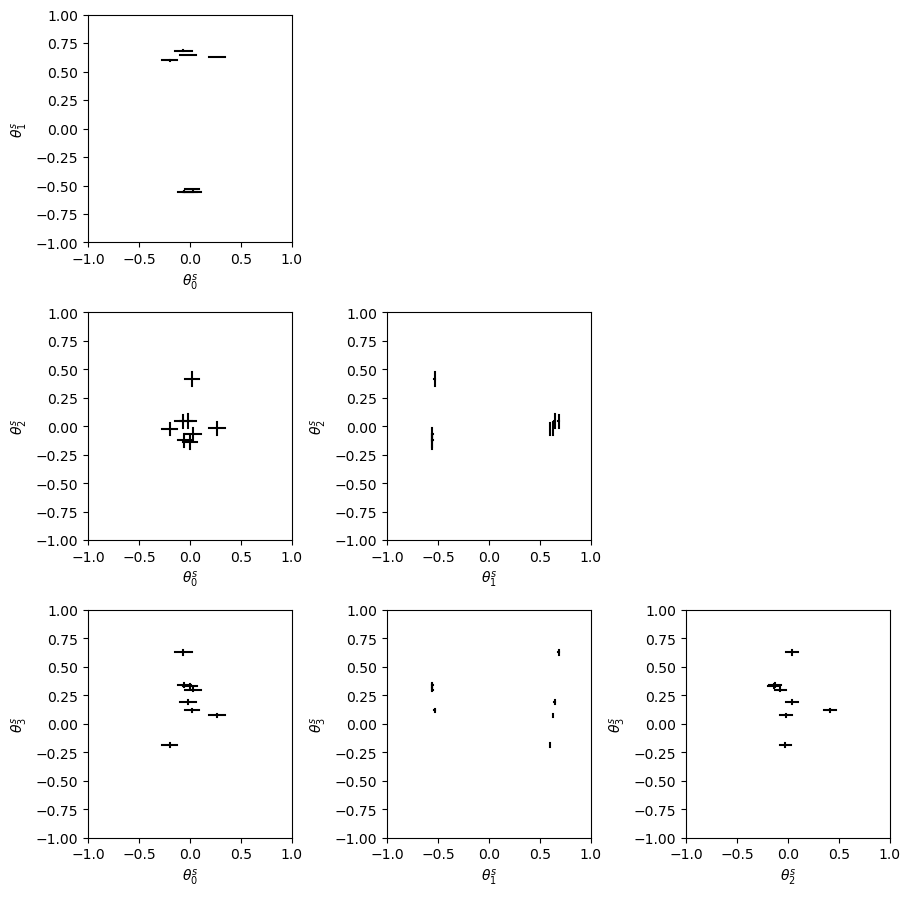

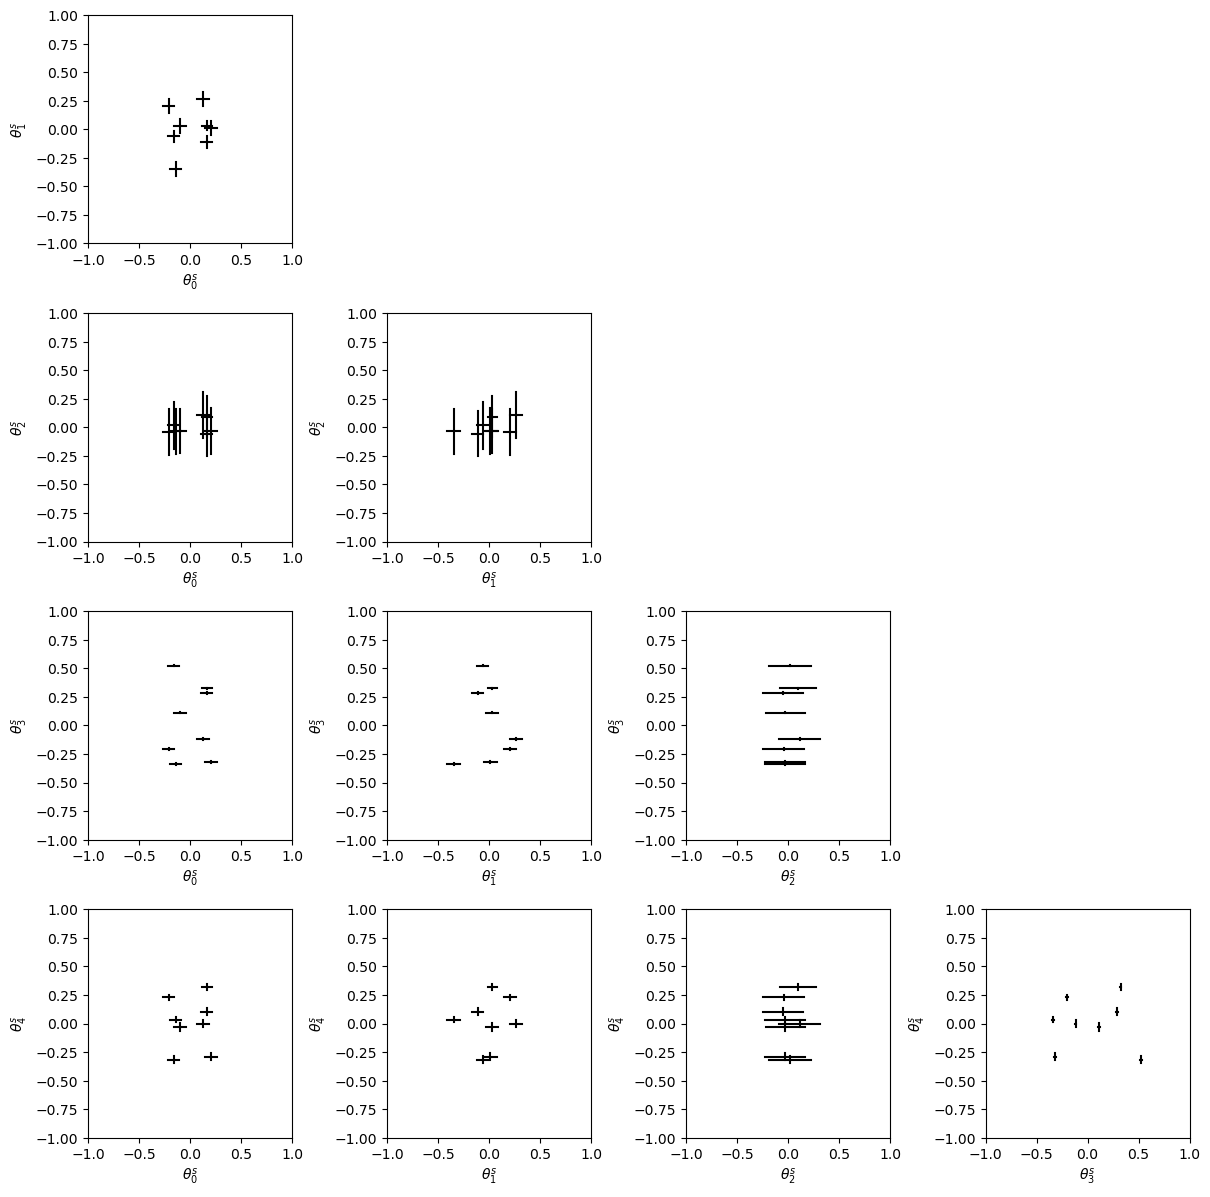

In [10]:

for iconf in range(nconf):

    tsub = paramss[iconf].thetasub
    msub = tsub.shape[1]

    plt.figure(figsize=(3*msub,3*msub), dpi=100)

    for i in range(msub):
        for j in range(msub):
            if i >= j: continue        

            plt.subplot2grid((msub,msub), (j,i))        
            nscatter(tsub[:,i,0], tsub[:,i,1], tsub[:,j,0], tsub[:,j,1])

            plt.xlabel(f"$\\theta^s_{i}$")
            plt.ylabel(f"$\\theta^s_{j}$")

            plt.xlim(-1,1)
            plt.ylim(-1,1)
            # plt.xticks([-2,0,2])
            # plt.yticks([-2,0,2])

    plt.tight_layout()


In [35]:
def calc_kl_sub(tsub, nsamples=10):
    nsub, msub, _ = tsub.shape
        
    kl = np.full((nsub, msub), np.nan)
    
    msub = tsub.shape[1]

    tsubmu  = tsub[:,:,0]
    tsubstd = tsub[:,:,1]
   
    tsub_samples = np.random.normal(tsubmu[:,:,None], tsubstd[:,:,None], size=(nsub, msub, nsamples))
    tsub2mu  = np.mean(np.reshape(tsub_samples, (msub, nsub*nsamples)), axis=1)
    tsub2std = np.std(np.reshape(tsub_samples, (msub, nsub*nsamples)), axis=1)
    
    for i in range(msub):
        kl[:,i] = (np.log(tsub2std[i]/tsubstd[:,i]) 
                   + (tsubstd[:,i]**2 + (tsubmu[:,i] - tsub2mu[i])**2)/(2*tsub2std[i]**2) - 0.5)
    
    
    return np.mean(kl, axis=0)

In [44]:
np.random.seed(42)
kls = [calc_kl_sub(params.thetasub, nsamples=10) for params in paramss]
orders = [np.argsort(-kl) for kl in kls]
sorted_kls = [kl[order] for kl, order in zip(kls, orders)]

In [43]:
print("   msub=1   msub=2   msub=3   msub=4   msub=5")
print("---------------------------------------------")

for j in range(maxmsub):
    for i in range(nconf): 
        if j < len(kls[i]):
            print(f"   {sorted_kls[i][j]:6.3f}", end='')
        else:
            print("      -  ", end='')
    print("")

   msub=1   msub=2   msub=3   msub=4   msub=5
---------------------------------------------
    3.757    3.727    3.668    6.102    4.598
      -      1.991    1.962    2.786    2.042
      -        -      1.441    1.380    1.347
      -        -        -      1.288    1.292
      -        -        -        -      0.128
